<a href="https://colab.research.google.com/github/lamalyon/ProjectMillion/blob/STOCKclassV3_20210503/scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install import-ipynb

In [2]:
import import_ipynb
from google.colab import drive

In [3]:
drive.mount("mnt",force_remount=True)

Mounted at mnt


In [4]:
%cd "mnt/My Drive/Day trading"

/content/mnt/My Drive/Day trading


In [5]:
from FUNCTIONS import *

importing Jupyter notebook from FUNCTIONS.ipynb


In [39]:
def getStock(ticker,start=None,end=None,p='3mo'):
    data = yf.Ticker(ticker).history(period=p,start=start,end=end,interval='1d')
    data = round(data,2)
    data.reset_index(inplace=True)
    #data['Up'] = round((data.High/data.Open) - 1,2)
    #data['Down'] = round((data.Low/data.Open)-1,2)
    #data['Spread'] = abs(data.Down) + data.Up
    data['Growth'] = round((data.Close/data.Open)-1,2)
    info = yf.Ticker(ticker).info
    info
    data['VolumeR'] = data.Volume/info['floatShares']
    return data

def formatStock(data):
    df = data[['Growth','VolumeR']]
    df['d1'] = df.Growth.shift(-1)
    df['d2'] = df.Growth.shift(-2)
    df['v1'] = df.VolumeR.shift(-1)
    df['v2'] = df.VolumeR.shift(-2)
    return df

def stockStat(df,ticker):

    d={}
    d['ticker'] = ticker
    d['+1+'] = round(len(df.loc[(df.Growth>0)&(df.d1>0)])/len(df.loc[(df.Growth>0)]),2)
    d['+2+'] = round(len(df.loc[(df.Growth>0)&(df.d1>0)&(df.d2>0)])/len(df.loc[(df.Growth>0)&(df.d1>0)]),2)
    d['-1+'] = round(len(df.loc[(df.Growth<0)&(df.d1>0)])/len(df.loc[(df.Growth<0)]),2)
    d['-2+'] = round(len(df.loc[(df.Growth<0)&(df.d1<0)&(df.d2>0)])/len(df.loc[(df.Growth<0)&(df.d1<0)]),2)
    d['+1-'] = round(len(df.loc[(df.Growth>0)&(df.d1<0)])/len(df.loc[(df.Growth>0)]),2)
    d['+2-'] = round(len(df.loc[(df.Growth>0)&(df.d1>0)&(df.d2<0)])/len(df.loc[(df.Growth>0)&(df.d1>0)]),2)
    d['-1-'] = round(len(df.loc[(df.Growth<0)&(df.d1<0)])/len(df.loc[(df.Growth<0)]),2)
    d['-2-'] = round(len(df.loc[(df.Growth<0)&(df.d1<0)&(df.d2<0)])/len(df.loc[(df.Growth<0)&(df.d1<0)]),2)
    d['+1='] = round(len(df.loc[(df.Growth>0)&(df.d1==0)])/len(df.loc[(df.Growth>0)]),2)
    d['+2='] = round(len(df.loc[(df.Growth>0)&(df.d1>0)&(df.d2==0)])/len(df.loc[(df.Growth>0)&(df.d1>0)]),2)
    d['-1='] = round(len(df.loc[(df.Growth<0)&(df.d1==0)])/len(df.loc[(df.Growth<0)]),2)
    d['-2='] = round(len(df.loc[(df.Growth<0)&(df.d1<0)&(df.d2==0)])/len(df.loc[(df.Growth<0)&(df.d1<0)]),2)
    return d

def stockScan(stockList, start=None,end=None,p='3mo',mode='test'):
    l=[]
    for i in stockList:
        if mode == 'test':
            try:
                temp = getStock(i,start=start,end=end,p=p)
                temp = formatStock(temp)
                stat = temp[:-4]
                test = temp[-4:-1]
                statReport = stockStat(stat,i)
                test = test[-3:][['Growth']].set_index(pd.Index(['d2','d1','d0'])).Growth.to_dict()
                statReport.update(test)
                l.append(statReport)
                #print(i)
            except:
                pass
        elif mode == 'trade':
            try:
                temp = getStock(i,start=start,end=end,p=p)
                temp=formatStock(temp)
                stat = temp[:-2]
                test = temp[-2:]
                statReport = stockStat(stat,i)
                test = test[-2:][['Growth']].set_index(pd.Index(['d2','d1'])).Growth.to_dict()
                test['d0'] = 0
                statReport.update(test)
                l.append(statReport)
                #print(i)
            except:
                pass
        print(i)
    df = pd.DataFrame(l)
    return df[['ticker','+1+','+1-','+1=','-1+','-1-','-1=','+2+','+2-','+2=','-2+','-2-','-2=','d2','d1','d0']]

def predict(data):
    df= data.copy()
    df.loc[(df['d1']<0)&(df['-1+']>0.5),'d1T'] = df.loc[(df['d1']<0)&(df['-1+']>0.5),'-1+']
    df.loc[(df['d1']<0)&(df['-1-']>0.5),'d1T'] = -df.loc[(df['d1']<0)&(df['-1-']>0.5),'-1-']
    df.loc[(df['d1']>0)&(df['+1+']>0.5),'d1T'] = df.loc[(df['d1']>0)&(df['+1+']>0.5),'+1+']
    df.loc[(df['d1']>0)&(df['+1-']>0.5),'d1T'] = -df.loc[(df['d1']>0)&(df['+1-']>0.5),'+1-']

    df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2+']>0.5),'d2T'] = df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2+']>0.5),'-2+']
    df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2-']>0.5),'d2T'] = -df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2-']>0.5),'-2-']
    df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2+']>0.5),'d2T'] = df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2+']>0.5),'+2+']
    df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2-']>0.5),'d2T'] = -df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2-']>0.5),'+2-']

    df.fillna(0,inplace=True)
    df.loc[(abs(df['d1T'])>=abs(df['d2T'])),'Trd'] = df.loc[(abs(df['d1T'])>abs(df['d2T'])),'d1T']
    df.loc[(abs(df['d1T'])<abs(df['d2T'])),'Trd'] = df.loc[(abs(df['d1T'])<abs(df['d2T'])),'d2T']

    #test just short
    #df.loc[df['Trd'] > 0,'Trd'] = df.loc[df['Trd']>0,'Trd']*-1

    df.loc[(df['Trd']>0)&(df['d0']>0),'result'] = 1
    df.loc[(df['Trd']<0)&(df['d0']<0),'result'] = 1
    df.loc[(df['Trd']>0)&(df['d0']<=0),'result'] = 0
    df.loc[(df['Trd']<0)&(df['d0']>=0),'result'] = 0
    return df

In [27]:
predict(stockScan(['BNGO'],mode='trade'))

,ticker,+1+,+1-,+1=,-1+,-1-,-1=,+2+,+2-,+2=,-2+,-2-,-2=,d2,d1,d0,d1T,d2T,Trd,result
0,BNGO,0.32,0.68,0.0,0.46,0.46,0.09,0.14,0.86,0.0,0.38,0.44,0.19,0.02,0.07,0,-0.68,-0.86,-0.86,0.0


In [20]:
l=[]
temp=formatStock(temp)
stat = temp[:-2]
test = temp[-2:]
statReport = stockStat(stat,'BNGO')
test = test[-2:][['Growth']].set_index(pd.Index(['d2','d1'])).Growth.to_dict()
test['d0'] = 0
statReport.update(test)
l.append(statReport)
l

[{'+1+': 0.32,
  '+1-': 0.68,
  '+1=': 0.0,
  '+2+': 0.14,
  '+2-': 0.86,
  '+2=': 0.0,
  '-1+': 0.44,
  '-1-': 0.47,
  '-1=': 0.09,
  '-2+': 0.38,
  '-2-': 0.44,
  '-2=': 0.19,
  'd0': 0,
  'd1': 0.07,
  'd2': 0.02,
  'ticker': 'BNGO'}]

In [8]:
stockList = [
'ZVO','WISH','RPHM','EVOK','BHR','DXF','PTIX','OBLN','POSH','YCBD','KBNT','AMWL','FLR','FREQ','CRIS','EYES','SQBG','CXDC','SIOX','LHDX','NCTY','TRQ','ATNF','MEIP','HYMC','INM','VIRX','EBON','MASS','EAR','RIOT','CNET','BFLY','ANIX','RNA','LEDS','PHUN','URGN','TUSK','WINT','MGTA','UVXY','BTX','EDU','EGLX','ONEM','BMBL','MICT','PATI','NTEC','PCT','SNMP','YQ','ZY','MARA','BFI','IKNA','AMTX','UAVS','HAE','SPRT','ZEPP','PRAX','OLO','ETNB','ELTK','TMCI','PETZ','PALI','SINO','VLDR','GRAY','INTZ','AGFY','HFFG','NNOX','BKTI','HGSH','VINO','DSP','LGO','PRLD','CAN','OPGN','TLIS','BEEM','DV','KBSF','BIVI','PED','SDPI','TAL','GRCL','ADN','REKR','AHPI','HRTX','QK','RYAM','KRT','APLT','PAAS','PRPO','DAO','AUTL','SONM','XBIO','TAOP','HOWL','FTFT','BIOC','DQ','STEM','WNW','DBTX','SHLS','ATIF','MSTR','LIVE','AVGR','VZIO','GMBL','PLSE','OYST','AIHS','NEW','MREO','ATER','VXX','YVR','CTXR','CHNR','YALA','PUBM','RMED','LIZI','VIXY','ALRN','SPI','AEVA','AMEH','CPNG','BCEL','GBS','SLP','SHC','LODE','LEE','ORTX','OEG','HIMS','JFU','REPX','PBF','KC','CSCW','UTME','GOOS','NVIV','CGEM','FEDU','XSPA','GNCA','OSH','CPE','BLNK','BIMI','PHIO','MSGM','GSHD','PFIE','OCG','GTBP','NBY','FUV','RETO','VTGN','SGA','TLMD','ABEO','NISN','KLDO','UPST','AEI','EM','PHAR','SNGX','DOYU','XCUR','DRIO','ADMS','IKT','QTRX','ALF','GLMD','OUST','UTZ','IPWR','NMRD','OIBR-C'
]
d={}
for i in range(2):
    end = datetime.date.today() - datetime.timedelta(i)
    if end.weekday() not in [5,6]:
        start = end - datetime.timedelta(32)
        data = stockScan(stockList,start=start,end=end)
        
        d[end] = predict(data)
    print(i)

- OEG: No data found for this date range, symbol may be delisted
0
1


In [40]:
stockList = [
'ZVO','WISH','RPHM','EVOK','BHR','DXF','PTIX','OBLN','POSH','YCBD','KBNT','AMWL','FLR','FREQ','CRIS','EYES','SQBG','CXDC','SIOX','LHDX','NCTY','TRQ','ATNF','MEIP','HYMC','INM','VIRX','EBON','MASS','EAR','RIOT','CNET','BFLY','ANIX','RNA','LEDS','PHUN','URGN','TUSK','WINT','MGTA','UVXY','BTX','EDU','EGLX','ONEM','BMBL','MICT','PATI','NTEC','PCT','SNMP','YQ','ZY','MARA','BFI','IKNA','AMTX','UAVS','HAE','SPRT','ZEPP','PRAX','OLO','ETNB','ELTK','TMCI','PETZ','PALI','SINO','VLDR','GRAY','INTZ','AGFY','HFFG','NNOX','BKTI','HGSH','VINO','DSP','LGO','PRLD','CAN','OPGN','TLIS','BEEM','DV','KBSF','BIVI','PED','SDPI','TAL','GRCL','ADN','REKR','AHPI','HRTX','QK','RYAM','KRT','APLT','PAAS','PRPO','DAO','AUTL','SONM','XBIO','TAOP','HOWL','FTFT','BIOC','DQ','STEM','WNW','DBTX','SHLS','ATIF','MSTR','LIVE','AVGR','VZIO','GMBL','PLSE','OYST','AIHS','NEW','MREO','ATER','VXX','YVR','CTXR','CHNR','YALA','PUBM','RMED','LIZI','VIXY','ALRN','SPI','AEVA','AMEH','CPNG','BCEL','GBS','SLP','SHC','LODE','LEE','ORTX','OEG','HIMS','JFU','REPX','PBF','KC','CSCW','UTME','GOOS','NVIV','CGEM','FEDU','XSPA','GNCA','OSH','CPE','BLNK','BIMI','PHIO','MSGM','GSHD','PFIE','OCG','GTBP','NBY','FUV','RETO','VTGN','SGA','TLMD','ABEO','NISN','KLDO','UPST','AEI','EM','PHAR','SNGX','DOYU','XCUR','DRIO','ADMS','IKT','QTRX','ALF','GLMD','OUST','UTZ','IPWR','NMRD','OIBR-C'
]
end = datetime.date.today()# - datetime.timedelta(1)
start = end - datetime.timedelta(32)
data = stockScan(stockList,start=start,end=end,mode='trade')    
df = predict(data)


ZVO
WISH
RPHM
EVOK
BHR
DXF
PTIX
OBLN
POSH
YCBD
KBNT
AMWL
FLR
FREQ
CRIS
EYES
SQBG
CXDC
SIOX
LHDX
NCTY
TRQ
ATNF
MEIP
HYMC
INM
VIRX
EBON
MASS
EAR
RIOT
CNET
BFLY
ANIX
RNA
LEDS
PHUN
URGN
TUSK
WINT
MGTA
UVXY
BTX
EDU
EGLX
ONEM
BMBL
MICT
PATI
NTEC
PCT
SNMP
YQ
ZY
MARA
BFI
IKNA
AMTX
UAVS
HAE
SPRT
ZEPP
PRAX
OLO
ETNB
ELTK
TMCI
PETZ
PALI
SINO
VLDR
GRAY
INTZ
AGFY
HFFG
NNOX
BKTI
HGSH
VINO
DSP
LGO
PRLD
CAN
OPGN
TLIS
BEEM
DV
KBSF
BIVI
PED
SDPI
TAL
GRCL
ADN
REKR
AHPI
HRTX
QK
RYAM
KRT
APLT
PAAS
PRPO
DAO
AUTL
SONM
XBIO
TAOP
HOWL
FTFT
BIOC
DQ
STEM
WNW
DBTX
SHLS
ATIF
MSTR
LIVE
AVGR
VZIO
GMBL
PLSE
OYST
AIHS
NEW
MREO
ATER
VXX
YVR
CTXR
CHNR
YALA
PUBM
RMED
LIZI
VIXY
ALRN
SPI
AEVA
AMEH
CPNG
BCEL
GBS
SLP
SHC
LODE
LEE
ORTX
OEG
HIMS
JFU
REPX
PBF
KC
CSCW
UTME
GOOS
NVIV
CGEM
FEDU
XSPA
GNCA
OSH
CPE
BLNK
BIMI
PHIO
MSGM
GSHD
PFIE
OCG
GTBP
NBY
FUV
RETO
VTGN
SGA
TLMD
ABEO
NISN
KLDO
UPST
AEI
EM
PHAR
SNGX
DOYU
XCUR
DRIO
ADMS
IKT
QTRX
ALF
GLMD
OUST
UTZ
IPWR
NMRD
OIBR-C


In [7]:
datetime.date.today()- datetime.timedelta(1)

datetime.date(2021, 5, 17)

In [45]:
df.loc[df.Trd>0].ticker.tolist()

['DXF',
 'YCBD',
 'FREQ',
 'SQBG',
 'MEIP',
 'INM',
 'RNA',
 'LEDS',
 'MGTA',
 'ZY',
 'IKNA',
 'ZEPP',
 'PRAX',
 'ETNB',
 'BKTI',
 'VINO',
 'PRLD',
 'OPGN',
 'BEEM',
 'REKR',
 'AHPI',
 'DQ',
 'LIVE',
 'GMBL',
 'MREO',
 'YVR',
 'LIZI',
 'REPX',
 'PBF',
 'CSCW',
 'FEDU',
 'GNCA',
 'PFIE',
 'OCG',
 'GTBP',
 'RETO',
 'TLMD',
 'ABEO',
 'ADMS']

In [9]:
df = pd.concat(d.values())
temp = df.loc[df.result.notnull(),'result']
temp.value_counts(normalize=True)

1.0    0.991071
0.0    0.008929
Name: result, dtype: float64

In [11]:
list(d.values())[2].result.value_counts(normalize=True)

0.0    1.0
Name: result, dtype: float64

In [ ]:
stockList = [
'ZVO','WISH','RPHM','EVOK','BHR','DXF','PTIX','OBLN','POSH','YCBD','KBNT','AMWL','FLR','FREQ','CRIS','EYES','SQBG','CXDC','SIOX','LHDX','NCTY','TRQ','ATNF','MEIP','HYMC','INM','VIRX','EBON','MASS','EAR','RIOT','CNET','BFLY','ANIX','RNA','LEDS','PHUN','URGN','TUSK','WINT','MGTA','UVXY','BTX','EDU','EGLX','ONEM','BMBL','MICT','PATI','NTEC','PCT','SNMP','YQ','ZY','MARA','BFI','IKNA','AMTX','UAVS','HAE','SPRT','ZEPP','PRAX','OLO','ETNB','ELTK','TMCI','PETZ','PALI','SINO','VLDR','GRAY','INTZ','AGFY','HFFG','NNOX','BKTI','HGSH','VINO','DSP','LGO','PRLD','CAN','OPGN','TLIS','BEEM','DV','KBSF','BIVI','PED','SDPI','TAL','GRCL','ADN','REKR','AHPI','HRTX','QK','RYAM','KRT','APLT','PAAS','PRPO','DAO','AUTL','SONM','XBIO','TAOP','HOWL','FTFT','BIOC','DQ','STEM','WNW','DBTX','SHLS','ATIF','MSTR','LIVE','AVGR','VZIO','GMBL','PLSE','OYST','AIHS','NEW','MREO','ATER','VXX','YVR','CTXR','CHNR','YALA','PUBM','RMED','LIZI','VIXY','ALRN','SPI','AEVA','AMEH','CPNG','BCEL','GBS','SLP','SHC','LODE','LEE','ORTX','OEG','HIMS','JFU','REPX','PBF','KC','CSCW','UTME','GOOS','NVIV','CGEM','FEDU','XSPA','GNCA','OSH','CPE','BLNK','BIMI','PHIO','MSGM','GSHD','PFIE','OCG','GTBP','NBY','FUV','RETO','VTGN','SGA','TLMD','ABEO','NISN','KLDO','UPST','AEI','EM','PHAR','SNGX','DOYU','XCUR','DRIO','ADMS','IKT','QTRX','ALF','GLMD','OUST','UTZ','IPWR','NMRD','OIBR-C'
]
stockScan(stockList,start=start,end=end)

ZVO
WISH


,ticker,+1+,+1-,+1=,-1+,-1-,-1=,+2+,+2-,+2=,-2+,-2-,-2=,d2,d1,d0
0,ZVO,0.14,0.86,0.0,0.50,0.42,0.08,0.0,1.0,0.0,0.60,0.40,0.0,0.02,0.05,-0.26
1,WISH,0.56,0.44,0.0,0.36,0.64,0.00,0.8,0.2,0.0,0.43,0.57,0.0,0.05,-0.03,-0.19


In [ ]:
end = datetime.date.today( ) - datetime.timedelta(1)
start = end - datetime.timedelta(32)
start

datetime.date(2021, 4, 13)

In [ ]:
def predict(data):
    df= data.copy()
    df.loc[(df['d1']<0)&(df['-1+']>0.5),'d1T'] = df.loc[(df['d1']<0)&(df['-1+']>0.5),'-1+']
    df.loc[(df['d1']<0)&(df['-1-']>0.5),'d1T'] = -df.loc[(df['d1']<0)&(df['-1-']>0.5),'-1-']
    df.loc[(df['d1']>0)&(df['+1+']>0.5),'d1T'] = df.loc[(df['d1']>0)&(df['+1+']>0.5),'+1+']
    df.loc[(df['d1']>0)&(df['+1-']>0.5),'d1T'] = -df.loc[(df['d1']>0)&(df['+1-']>0.5),'+1-']

    df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2+']>0.5),'d2T'] = df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2+']>0.5),'-2+']
    df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2-']>0.5),'d2T'] = -df.loc[(df['d1']<0)&(df['d2']<0)&(df['-2-']>0.5),'-2-']
    df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2+']>0.5),'d2T'] = df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2+']>0.5),'+2+']
    df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2-']>0.5),'d2T'] = -df.loc[(df['d1']>0)&(df['d2']>0)&(df['+2-']>0.5),'+2-']

    df.fillna(0,inplace=True)
    df.loc[(abs(df['d1T'])>=abs(df['d2T'])),'Trd'] = df.loc[(abs(df['d1T'])>abs(df['d2T'])),'d1T']
    df.loc[(abs(df['d1T'])<abs(df['d2T'])),'Trd'] = df.loc[(abs(df['d1T'])<abs(df['d2T'])),'d2T']

    df.loc[(df['Trd']>0)&(df['d0']>0),'result'] = 1
    df.loc[(df['Trd']<0)&(df['d0']<0),'result'] = 1
    df.loc[(df['Trd']>0)&(df['d0']<=0),'result'] = 0
    df.loc[(df['Trd']<0)&(df['d0']>=0),'result'] = 0
    return df

In [ ]:
df

,ticker,+1+,+1-,+1=,-1+,-1-,-1=,+2+,+2-,+2=,-2+,-2-,-2=,d2,d1,d0,d1T,d2T,Trd,result
0,WISH,0.47,0.5,0.03,0.34,0.62,0.03,0.56,0.44,0.0,0.39,0.56,0.06,0.05,-0.03,-0.19,-0.62,0.00,-0.62,1.0
1,ZVO,0.42,0.5,0.09,0.39,0.49,0.12,0.38,0.52,0.1,0.43,0.45,0.12,0.02,0.05,-0.26,0.00,-0.52,-0.52,1.0


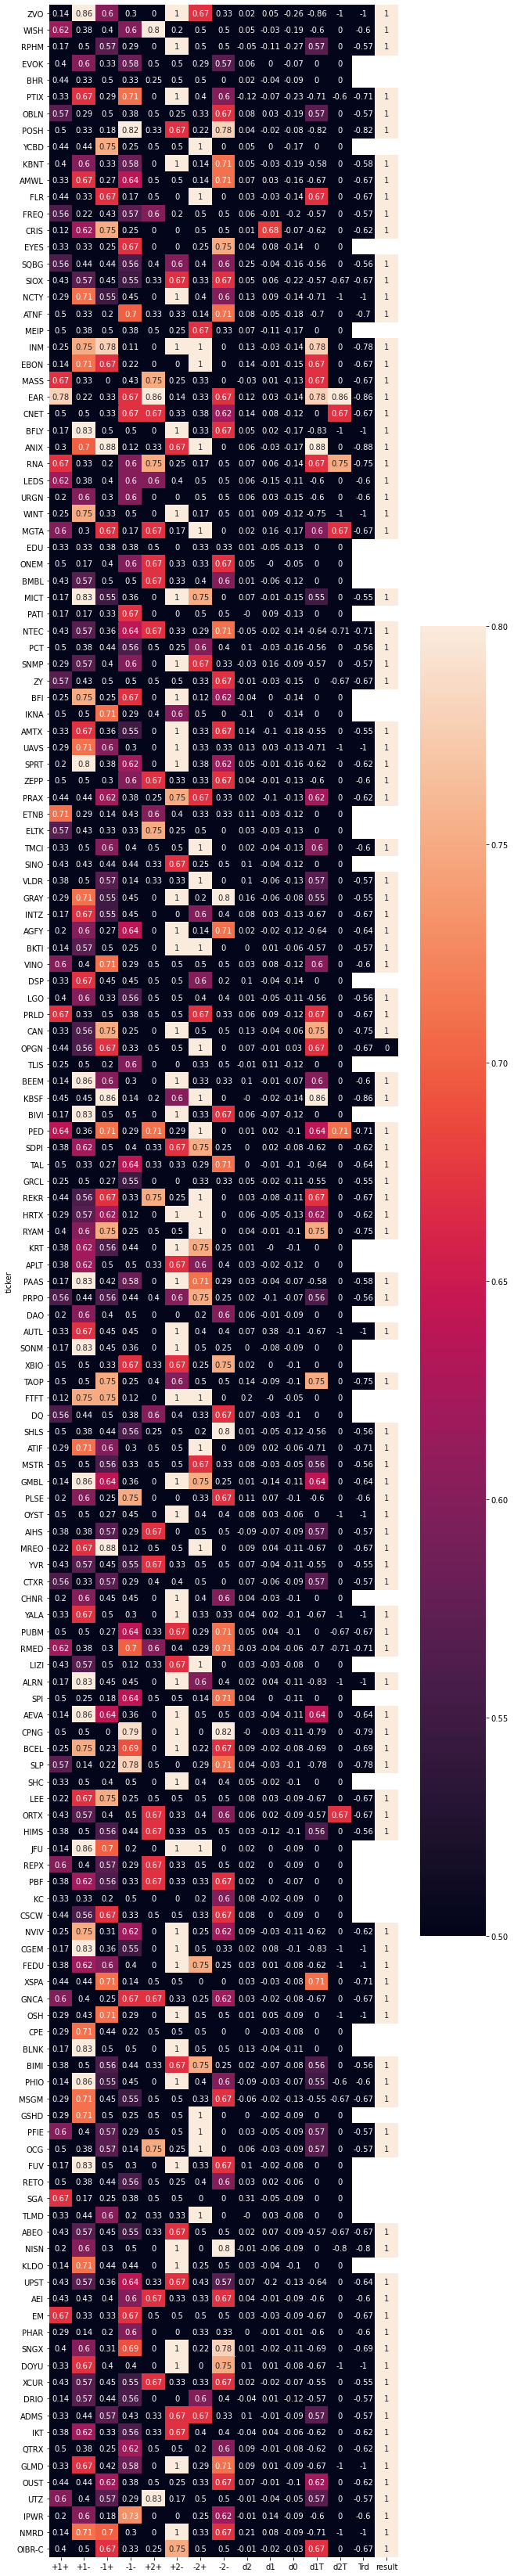

In [11]:
fig, ax = plt.subplots(figsize=(10,60))
temp=df.drop(['+1=','-1=','+2=','-2='],axis=1).set_index('ticker')

sns.heatmap(temp,annot=True,vmax=.8,vmin=.5)

In [8]:
getStock('BNGO')

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Growth,VolumeR
0,2021-02-16,14.59,15.69,14.07,15.57,55178600,0,0,0.07,0.199459
1,2021-02-17,14.71,15.09,13.60,14.54,32034500,0,0,-0.01,0.115798
2,2021-02-18,13.59,13.81,12.50,12.82,28869300,0,0,-0.06,0.104357
3,2021-02-19,13.48,14.35,13.23,13.57,20448000,0,0,0.01,0.073915
4,2021-02-22,12.77,13.38,11.61,11.85,28809400,0,0,-0.07,0.104140
...,...,...,...,...,...,...,...,...,...,...
58,2021-05-10,5.52,5.54,4.93,5.01,20808700,0,0,-0.09,0.075219
59,2021-05-11,4.51,5.19,4.46,5.12,19699600,0,0,0.14,0.071210
60,2021-05-12,4.95,5.17,4.70,4.74,16367700,0,0,-0.04,0.059166
61,2021-05-13,4.83,4.94,4.30,4.41,30359400,0,0,-0.09,0.109743
